# Problema 49
Integraremos un N-Body, utilizando el método **LF-KDK** con un paso de $h = 0.1$ durante $t=500$ para una distribución de $N=200$ pts que siguen el perfil de densidad radial
### <center> $n(r) = \sigma_0 e^{r/r_s}$ </center>
Si supongo $r_s = 100$, según la ecuación 2.165 del *Galactic Dynamics*, pido velocidades iniciales $(\dot \phi)$:
### <center> $v^2(r) = 400\pi r'^2 \cdot [I_0(r')K_0(r') - I_1(r')K_1(r')]$ ; $r' = \frac{r}{2 \cdot 100}$ </center>
Contenidos en un círculo de radio $R \approx 800$. <br>
Supondremos $G=1$, $m_i = m = 1$  $\forall i \in (1,...,N)$ ; $\sigma_0 = 1$

In [1]:
using Plots
using Random
using LinearAlgebra
using Statistics
using SpecialFunctions

#Necesito las func usadas en P42 para obtener la distrib:

rs = 100

function f(x,y0) #Se come al "y0" ~ U(0,1)
    g = (1 - exp(-x/rs)*(1+x/rs)) - y0
    return g
end
#Bisección:

function bisec(xl,xu,y0) #xl = xmin del bracket; xu = xmax del bracket
    
    e = abs(xu-xl) #error
    xm = zeros(1)
    
    #println("$e , $xl , $xu")
        
    for i in 1:1000 #el loop se corta cuando se llega a la precisión requerida o se pasa el número de iteraciones
    
        xm = 0.5*(xl+xu) #punto medio
        #println("$xm")
        if f(xl,y0)*f(xm,y0) < 0 #test para nuevo bracket
            xu = xm
        
        elseif f(xl,y0)*f(xm,y0) == 0
            println("La raíz de f(x) es",xm)
            e = 0
            break
        
        else
            xl = xm
        
        end
        
        e = abs(xu - xl) #test del error
        
        if e < 1e-6
            break #Me faltaba hacer a "xm" global dentro de la func
        end
        
    end
    
    return xm::Float64
    
end

function distrib(n=100,R=15. *rs,s=1) #n = cant de partículas
                                           #R = Radio máximo de las partículas del disco
                                           #s = seed a elegir (para cambiar if I wanna)
    
    Random.seed!(s) #pickeo seed
    
    phi = 2*pi*rand(n) #randoms uniformes entre 0 y 1.
    r = zeros(n)
    v = zeros(n)
    vx = zeros(n)
    vy = zeros(n)
    
    for i in 1:n
        y0 = rand(1)[1] #Tiro 1 random
        r[i] = bisec(0.,R,y0)
        
        #Asignemos velocidades
        
        h = r[i]/(2*rs) #" r' "
        v[i] = 4*pi*rs*h^2(besseli(0,h)*besselk(0,h) - besseli(1,h)*besselk(1,h)) #La ecuac
        v[i] = sqrt(v[i])/50 #El módulo (ojo que lo modifiqué para ver si se quedan en equilibrio...) (modd el denominador)
        
        vx[i] = -v[i]*sin(phi[i])
        vy[i] = v[i]*cos(phi[i])
        
    end
    
    x = r.*cos.(phi)
    y = r.*sin.(phi)
    
    #Energía:
    
    E = 0.
    
    for i in 1:n
        for j in 1:n
            if i == j
                continue
            else
                d = norm((x[i]-x[j],y[i]-y[j]))
                E += -1/d #La pot
            end        
        end
        
        E += 0.5*(v[i])^2 #La cinét
        
    end
    
    return x,y,vx,vy,E
end

distrib (generic function with 4 methods)

In [2]:
x,y,vx,vy,E0 = distrib(200);

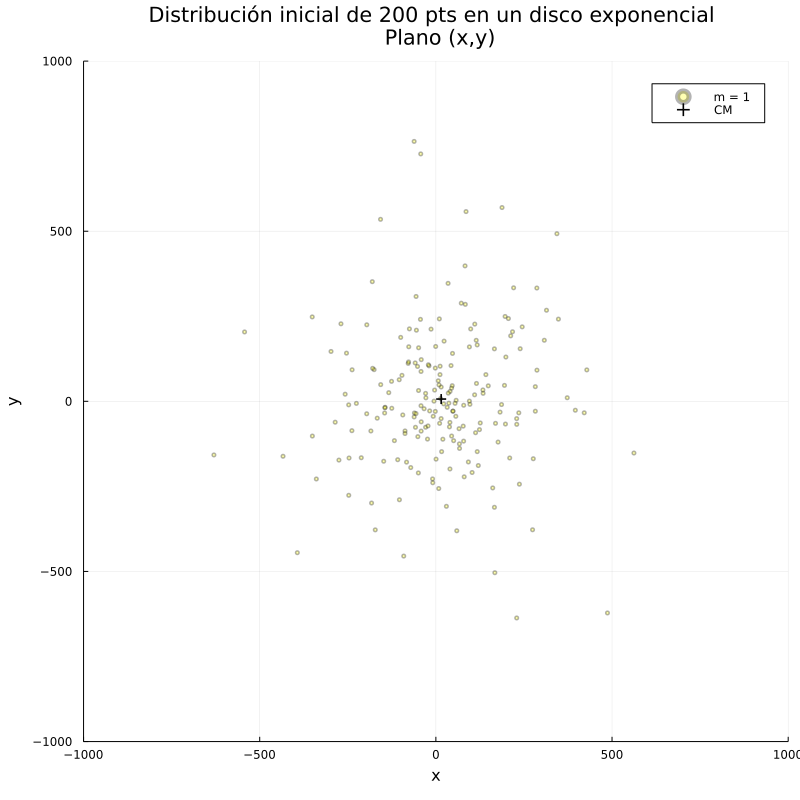

In [3]:
plt = scatter(x,y, xlabel="x", ylabel="y", title = "Distribución inicial de $(size(x)[1]) pts en un disco exponencial \n Plano (x,y)",
             label="m = 1",  ms=2,color="yellow", grid = true,size=(800,800), alpha=0.3,
             xlim=(-10*rs,10*rs),ylim=(-10*rs,10*rs)) #ploteo

x_cm = mean(x)
y_cm = mean(y)

plt = scatter!([x_cm],[y_cm],color="black",seriestype = :scatter,label="CM", legend=true,  ms=5, shape=:cross)

display(plt)

In [4]:
m = 1

#Aceleración:

function a(x=x,y=y,e=0.5,n=size(x)[1])  #aceleración de cada partícula debido al resto (sup G = 1)
                                            #e = softening; n = cant de part, debe ser = al n de distrib
        
    ax = zeros(n)
    ay = zeros(n)
    
    for i in 1:n
        
        Sx = 0 #Var para sum. Para c/ part debo ver cómo le afectan las demás
        Sy = 0 #Direcc ortog => lo puedo cal por separado
        
        for j in 1:n
            if i == j
                continue
            else
                r = norm((x[i]-x[j],y[i]-y[j])) #módulo del vector dif entre particulas i y j
                Sx += (r^2 + e^2)^-1.5 * (x[i]-x[j])*m
                Sy += (r^2 + e^2)^-1.5 * (y[i]-y[j])*m
                
            end
    
        ax[i] = -Sx/m
        ay[i] = -Sy/m
                
        end 
                
    end
        
    return ax,ay #a = un array de n listas (= cant de aprticulas), con las aceleraciones en x y en y de cada espacio
                
end

a (generic function with 5 methods)

In [5]:
function LF(a=a,x=x,y=y,vx=vx,vy=vy,h=0.1,t=500,N=size(x)[1])
            #(x,y) listas vacías excepto por las pos inic, (vx,vy) variables, pero comenzamos con las v inic.
            # a = (ax,ay) func para obtener la aceleración; n = cant de pasos; t = tiempo de integ
            # N = cant de part = n anteriores    
    kx = zeros(N)
    ky = zeros(N)

    n = Int64(t/h)
    dE = zeros(n) #Delta E para c/ step
    
    for m in 1:n #pasos a realizar
        
        E = 0.
        
        for i in 1:N #cant de partículas
        
            kx[i] = vx[i] + a(x,y)[1][i]*h/2 #la func a se come las posiciones de todas las partículas, pero
                                             #siempre estoy viendo la particula i, y actualizo las pos y vel de cada part a la vez
                                             #antes de saltar al prox step m
            
            ky[i] = vy[i] + a(x,y)[2][i]*h/2
            
        end
            
        for i in 1:N #Debo ir actualizando k, x y v de todas las part antes de pasar al prox parám (k -> x -> v) 

            x[i] = x[i] + kx[i]*h
            y[i] = y[i] + ky[i]*h
            
            #println(x[1])
            
        end
            
        for i in 1:N

            vx[i] = kx[i] + a(x,y)[1][i]*h/2 #Esta a es con las pos de TODAS las part actualizadas (no sólo de 1, que es lo que
                                             # pasaría si estuvieran k, x y v en el mismo loop)
            vy[i] = ky[i] + a(x,y)[2][i]*h/2
            
        end
        
        for i in 1:N
            for j in 1:N
                if i == j
                    continue
                else
                    d = norm((x[i]-x[j],y[i]-y[j]))
                    E += -1/d
                end        
            end

            E += 0.5*(norm((vx[i],vy[i])))^2
            
        end
        
        dE[m] = (E-E0)/E0
        
        #Y ahora si podemos pasar al prox step, guardando imags para la prox anim
        
        if mod(m,10) == 0

                plt = scatter(x,y, xlabel="x", ylabel="y", title = "N-body LF Problema 49): \n h = $h ; N = $N",
                           color="yellow",seriestype = :scatter, legend=false, ms=3, grid = true,
                           xlim = (-15*rs,15*rs), ylim = (-15*rs,15*rs),size=(800,800), alpha=0.4) #ploteo
            
            
                x_cm = mean(x)
                y_cm = mean(y)
    
                plt = scatter!([x_cm],[y_cm],color="black",seriestype = :scatter,label="CM", legend=true,  ms=5, shape=:cross)
            
                #display(plt)
                savefig(plt,"P49_Nbody_$(m).png")
            
        end
     
    end
                        
    return x,y,vx,vy,dE #Para seguirlo si quiero desde donde lo dejó. Funcó

end

LF (generic function with 9 methods)

No realizaremos de nuevo la integración, mostraremos la animación en el siguiente link:

https://drive.google.com/file/d/1vXRWVQGTyQ8dMa6dIbHv9gxRSBBwrqBk/view?usp=sharing

In [6]:
#x,y,vx,vy,dE = LF();

In [48]:
using DelimitedFiles
using DataFrames
using CSV

#writedlm( "N-BodyP49_t50_1000.csv",  (x,y,vx,vy,dE), ',')
df = DataFrame(CSV.File("N-BodyP49_t50_1000.csv",header=false,delim=','))

dE_df = df[4,:]

┌ Warning: thread = 1 warning: parsed expected 200 columns, but didn't reach end of line around data row: 5. Parsing extra columns and widening final columnset
└ @ CSV C:\Users\Usuario\.julia\packages\CSV\cHirL\src\file.jl:579


,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
4,-0.0140625,-0.29422,-0.273134,-0.254014,-0.723672,1.28883,0.374245,0.542298


In [50]:
dE = zeros(200)
for i in 1:200
   dE[i] = dE_df[i] 
end

Y dejamos el plot de $\Delta E(t)$ para el sistema

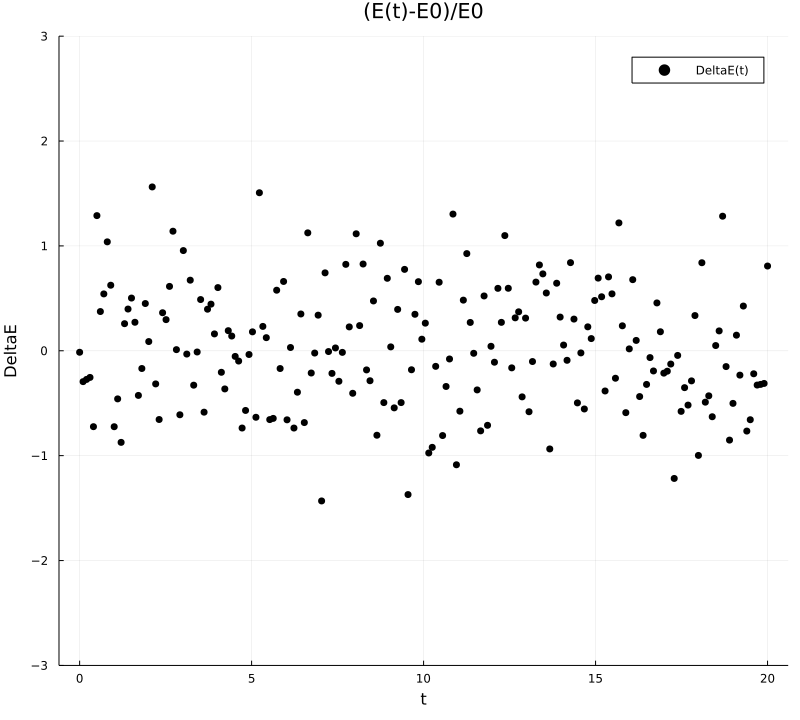

In [51]:
t = LinRange(0,20,200)
p = scatter(t,dE,title="(E(t)-E0)/E0",lw=3,color="black",label="DeltaE(t)",xlabel="t",ylabel="DeltaE",size=(800,720),
            ylim=(-3,3))
display(p)